In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
from matplotlib import style
import pymysql

In [2]:
conn = pymysql.connect(host='localhost', port = int(3306), user='root', passwd='1a_2b_3c_4d$', db='supermarket')
conn

**Our data is supermarket sales data for 2019: "The first Quarter only". So, let's first query the required data format as a view with the appropriate comlumn type**

In [3]:
#checking data type

data_type = pd.read_sql_query("""SELECT 
    COLUMN_NAME, DATA_TYPE
FROM
    INFORMATION_SCHEMA.COLUMNS
WHERE
    TABLE_NAME = 'supermarket_sales'""", conn)

data_type

,COLUMN_NAME,DATA_TYPE
0,Invoice ID,text
1,Branch,text
2,City,text
3,Customer type,text
4,Gender,text
5,Product line,text
6,Unit price,double
7,Quantity,int
8,Tax 5%,double
9,Total,double


In [4]:
#querying required data

supermarket = pd.read_sql_query("""SELECT 
        `Invoice ID`,
        STR_TO_DATE(date, '%c/%e/%Y') AS Date,
        monthname(STR_TO_DATE(date, '%c/%e/%Y')) as Month,
        Branch,
        City,
        `Customer type`,
        Gender,
        `Product Line`,
        Payment,
        `gross income` AS `Net Profit`,
        Rating
    FROM
    supermarket_sales
""", conn)

supermarket

,Invoice ID,Date,Month,Branch,City,Customer type,Gender,Product Line,Payment,Net Profit,Rating
0,750-67-8428,2019-01-05,January,A,Yangon,Member,Female,Health and beauty,Ewallet,26.1415,9.1
1,226-31-3081,2019-03-08,March,C,Naypyitaw,Normal,Female,Electronic accessories,Cash,3.8200,9.6
2,631-41-3108,2019-03-03,March,A,Yangon,Normal,Male,Home and lifestyle,Credit card,16.2155,7.4
3,123-19-1176,2019-01-27,January,A,Yangon,Member,Male,Health and beauty,Ewallet,23.2880,8.4
4,373-73-7910,2019-02-08,February,A,Yangon,Normal,Male,Sports and travel,Ewallet,30.2085,5.3
...,...,...,...,...,...,...,...,...,...,...,...
817,832-51-6761,2019-01-19,January,A,Yangon,Normal,Male,Food and beverages,Ewallet,13.5520,9.6
818,869-11-3082,2019-01-27,January,B,Mandalay,Member,Male,Health and beauty,Credit card,19.2320,8.4
819,190-59-3964,2019-02-03,February,B,Mandalay,Member,Male,Food and beverages,Credit card,11.7900,6.0
820,366-43-6862,2019-03-25,March,B,Mandalay,Normal,Male,Electronic accessories,Ewallet,10.5780,6.7


In [5]:
#checking data types

supermarket.dtypes

Invoice ID        object
Date              object
Month             object
Branch            object
City              object
Customer type     object
Gender            object
Product Line      object
Payment           object
Net Profit       float64
Rating           float64
dtype: object

In [6]:
#checking data stats
supermarket.describe()

,Net Profit,Rating
count,822.000000,822.000000
mean,15.488663,7.007543
std,11.657488,1.720307
min,0.604500,4.000000
25%,6.257750,5.600000
50%,12.123000,7.000000
75%,22.702000,8.500000
max,49.650000,10.000000


In [7]:
#checking null values
supermarket.isnull().sum()

Invoice ID       0
Date             0
Month            0
Branch           0
City             0
Customer type    0
Gender           0
Product Line     0
Payment          0
Net Profit       0
Rating           0
dtype: int64

<AxesSubplot:title={'center':'Supermarket Outliers'}>

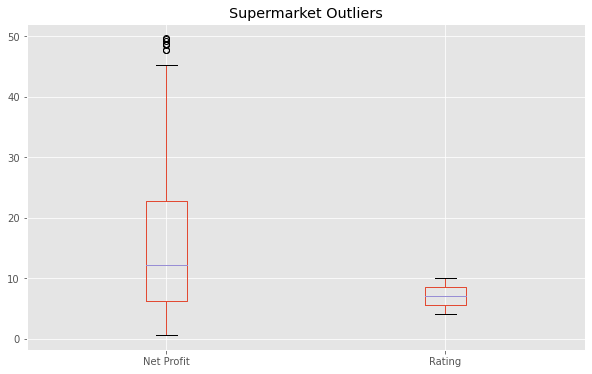

In [8]:
#checking and visualizing outliers
plt.figure(figsize=(10,6))
plt.style.use('ggplot')
plt.title('Supermarket Outliers')
supermarket.boxplot()

*It seems that the net profit contains some of the nonreliable data where as rating is just fine, however the outliers seem to be very small in number so we won't be dealing with them right now till we make sure how they influenced our data.*

## Let's visualize overall Net Profit regarding the first quarter data

In [9]:
first_quarter = pd.read_sql_query("""SELECT 
    Month, ROUND(SUM(`Net Profit`), 2) AS `Total Net Profit`
FROM
    supermarket
GROUP BY Month""", conn)

first_quarter

,Month,Total Net Profit
0,January,4445.14
1,March,4388.70
2,February,3897.84


Text(0.5, 1.0, 'First Quarter Net Profit')

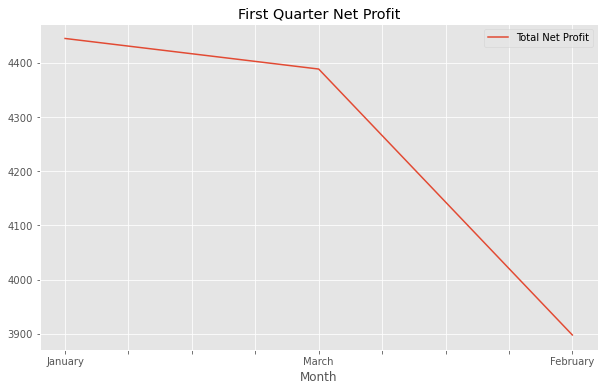

In [10]:
#visualizing the first quarter net profit

first_quarter.set_index('Month').plot(kind='line', figsize=(10,6))
plt.title('First Quarter Net Profit')

*=> It's clear that the Net Profit had been depreciating over the first 3 months in 2019.*

## Let's analyze the overall rating regarding the first quarter

In [11]:
rating = pd.read_sql_query("""SELECT 
    month, ROUND(AVG(rating), 2) AS `Average Rating`
FROM
    supermarket
GROUP BY month""", conn)

rating

,Month,Average Rating
0,January,7.08
1,March,6.84
2,February,7.12


*=> Customer dissatisfaction appears from the significant decrease in the average rating regarding the first quarter in 2019.*

## So, let's dive deeper and analyze each branch / City "Location" to discover where the problem lies

In [12]:
Branch_pct_profit = pd.read_sql_query("""SELECT 
    Branch,
    city,
    round(100 * SUM(`Net Profit`) / (SELECT 
            SUM(`Net Profit`)
        FROM
            supermarket),2) AS `% Net Profit`
FROM
    supermarket
GROUP BY branch , city""", conn)

Branch_pct_profit

,Branch,City,% Net Profit
0,A,Yangon,32.24
1,C,Naypyitaw,35.09
2,B,Mandalay,32.68


Text(0.5, 0, '%Net Profit')

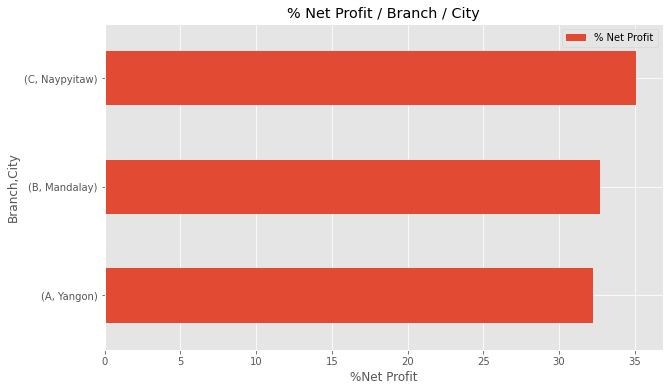

In [13]:
#visualizing branch/city % Net Profit

Branch_pct_profit.set_index(['Branch', 'City']).sort_values('% Net Profit').plot(kind='barh', figsize=(10,6))
plt.title('% Net Profit / Branch / City')
plt.xlabel('%Net Profit')

*=> It's clear that Branch C, Naypyitaw is forming the largest share of net profit with a percentage of 35.09% followed by Branch B, Mandalay 32.68%, ending with branch A, Yangon 32.24%.* 

In [14]:
Prod_Line_pct_profit = pd.read_sql_query("""SELECT 
    `Product Line`,
    ROUND(100 * SUM(`Net Profit`) / (SELECT 
                    SUM(`Net Profit`)
                FROM
                    supermarket),
            2) AS `% Net Profit`
FROM
    supermarket
GROUP BY `Product Line`
ORDER BY 2 DESC""",conn)

Prod_Line_pct_profit


,Product Line,% Net Profit
0,Sports and travel,17.80
1,Fashion accessories,17.71
2,Food and beverages,17.63
3,Home and lifestyle,16.72
4,Electronic accessories,15.73
5,Health and beauty,14.40


Text(0.5, 0, '% Net Profit')

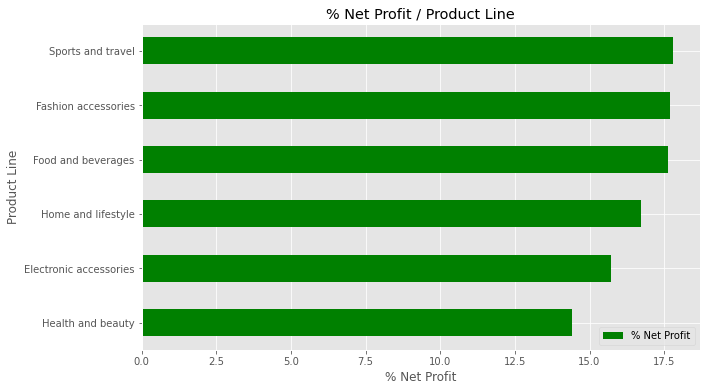

In [15]:
Prod_Line_pct_profit.set_index('Product Line').sort_values('% Net Profit').plot(kind='barh', figsize=(10,6), color='g')
plt.title('% Net Profit / Product Line')
plt.xlabel('% Net Profit')

**=> It's clear that the top 3 Product lines, forming nearly the same net profit, are:**

        1- Sports & Travel
        2-Fashion accessories
        3-Food & Beverages


## Let's analyze the payment methods

In [16]:
payment = pd.read_sql_query("""SELECT 
    Payment,
    ROUND(100 * SUM(`Net Profit`) / (SELECT 
                    SUM(`Net Profit`)
                FROM
                    supermarket),
            2) as "% Net Profit"
FROM
    SUPERMARKET
GROUP BY payment
ORDER BY 2 DESC""", conn)

payment

,Payment,% Net Profit
0,Cash,34.34
1,Ewallet,34.01
2,Credit card,31.65


Text(0.5, 0, '%Net Profit')

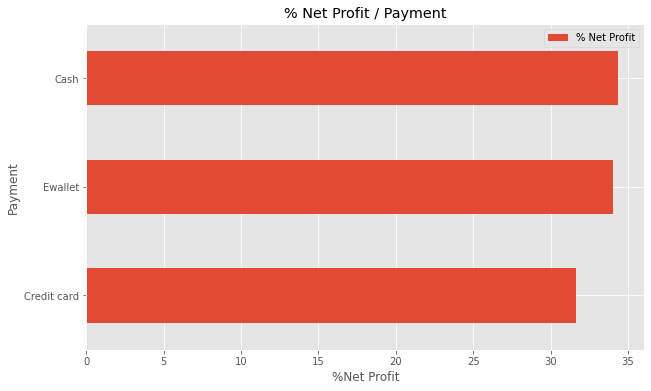

In [17]:
#visualizing payment methods % Net Profit

payment.set_index("Payment").sort_values('% Net Profit').plot(kind='barh', figsize=(10,6))
plt.title('% Net Profit / Payment')
plt.xlabel('%Net Profit')

*=> Cash and Ewallet are nearly equal when it comes to % Net profit followed by credit card which is ranked as third among them*

## Let's analyze the gender of customers

In [18]:
gender = pd.read_sql_query("""SELECT 
    Gender,
    ROUND(100 * SUM(`Net Profit`) / (SELECT 
                    SUM(`Net Profit`)
                FROM
                    supermarket),
            2) as "% Net Profit"
FROM
    SUPERMARKET
GROUP BY Gender
ORDER BY 2 DESC""",conn)

gender

,Gender,% Net Profit
0,Female,51.18
1,Male,48.82


array([<AxesSubplot:ylabel='% Net Profit'>], dtype=object)

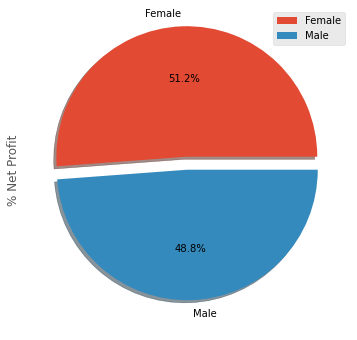

In [19]:
gender.set_index('Gender').plot(kind='pie', subplots=True, explode=(0.1,0),shadow=True, autopct='%1.1f%%', figsize=(10,6))

*=> Most of the Customers are females*

## Now, let's analyze by customer type

In [20]:
cust_type = pd.read_sql_query("""SELECT 
    `Customer type`,
    ROUND(100 * SUM(`Net Profit`) / (SELECT 
                    SUM(`Net Profit`)
                FROM
                    supermarket),
            2) as "% Net Profit"
FROM
    SUPERMARKET
GROUP BY `Customer type`
ORDER BY 2 DESC""",conn)

cust_type

,Customer type,% Net Profit
0,Member,51.42
1,Normal,48.58


array([<AxesSubplot:ylabel='% Net Profit'>], dtype=object)

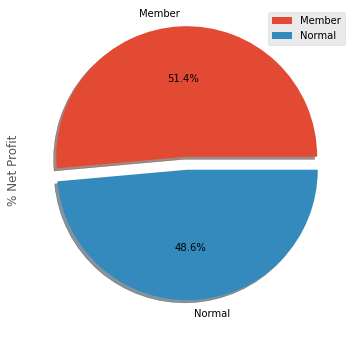

In [21]:
cust_type.set_index('Customer type').plot(kind='pie', subplots=True, explode=(0.1,0),shadow=True, autopct='%1.1f%%', figsize=(10,6))

*=> The highest Net Profit share is formed from members not normal customers. i.e. Membership increases overall profit.*

# Let's figure out if there's a relationship between Net Profit and Rating

In [22]:
df = pd.read_sql_query("""SELECT * FROM SUPERMARKET""",conn)
df

,Invoice ID,Date,Month,Branch,City,Customer type,Gender,Product Line,Payment,Net Profit,Rating
0,750-67-8428,2019-01-05,January,A,Yangon,Member,Female,Health and beauty,Ewallet,26.1415,9.1
1,226-31-3081,2019-03-08,March,C,Naypyitaw,Normal,Female,Electronic accessories,Cash,3.8200,9.6
2,631-41-3108,2019-03-03,March,A,Yangon,Normal,Male,Home and lifestyle,Credit card,16.2155,7.4
3,123-19-1176,2019-01-27,January,A,Yangon,Member,Male,Health and beauty,Ewallet,23.2880,8.4
4,373-73-7910,2019-02-08,February,A,Yangon,Normal,Male,Sports and travel,Ewallet,30.2085,5.3
...,...,...,...,...,...,...,...,...,...,...,...
817,832-51-6761,2019-01-19,January,A,Yangon,Normal,Male,Food and beverages,Ewallet,13.5520,9.6
818,869-11-3082,2019-01-27,January,B,Mandalay,Member,Male,Health and beauty,Credit card,19.2320,8.4
819,190-59-3964,2019-02-03,February,B,Mandalay,Member,Male,Food and beverages,Credit card,11.7900,6.0
820,366-43-6862,2019-03-25,March,B,Mandalay,Normal,Male,Electronic accessories,Ewallet,10.5780,6.7


In [23]:
#finding correlation

df[['Net Profit','Rating']].corr()

,Net Profit,Rating
Net Profit,1.000000,-0.022104
Rating,-0.022104,1.000000


In [24]:
#evaluating pearson coeff and p-value

pearson_coef, p_value = stats.pearsonr(df['Net Profit'],df['Rating'])
pearson_coef, p_value

(-0.022104162590205638, 0.5268307776407168)

**The correlation between Net Profit and Rating is weak. Thus, Rating is independent of Net Profit. This correlation is statistically significant. i.e. Not due to chance.**

<AxesSubplot:title={'center':'Relationship between Rating and Net Profit'}, xlabel='Net Profit', ylabel='Rating'>

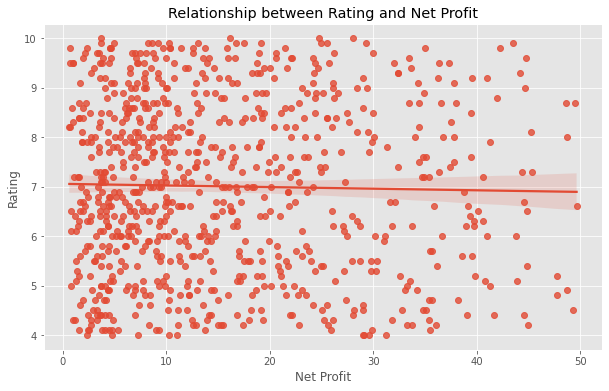

In [25]:
#Visualizing the results

plt.figure(figsize=(10,6))
plt.title('Relationship between Rating and Net Profit')
sns.regplot(x='Net Profit', y='Rating', data=df)

# Data Findings:

1- The net profit contains some of the nonreliable data where as rating is just fine, however the outliers seem to be very   
   small in number so we won't be dealing with them 
 
2- The Net Profit had been depreciating over the first 3 months in 2019.

3- Customer dissatisfaction appears from the significant decrease in the average rating regarding the first quarter in 2019.

4- Branch C, Naypyitaw is forming the largest share of net profit with a percentage of 35.09% followed by Branch B, Mandalay   
   32.68%, ending with branch A, Yangon 32.24%.

5- The top 3 Product lines, forming nearly the same net profit, are:

    *a- Sports & Travel*
    *b-Fashion accessories*
    *c-Food & Beverages*
    
6- Cash and Ewallet payment methods are nearly equal when it comes to % Net profit followed by credit card which is ranked as  
   third among them
   
7- Most of the Customers are females

8- The highest Net Profit share is formed from members not normal customers. i.e. Membership increases overall profit.

9- The correlation between Net Profit and Rating is weak. Thus, Rating is independent of Net Profit. This correlation is 
   statistically significant. i.e. Not due to chance.

In [26]:
df.to_csv('supermarket.csv')